In [1]:
import sys
sys.path += ["../src"]

from data_component import DataComponent
# from opinion_diffusion_component import FJDiffusionComponent



In [98]:
from abc import ABC, abstractmethod
import networkx as nx
from sklearn.preprocessing import normalize, StandardScaler
import numpy as np



class OpinionDiffusionComponent(ABC):
    @abstractmethod
    def propagate_message_at_equilibrium(self, message, node_id):
        raise NotImplementedError()

    @abstractmethod
    def propagate_message_one_step(self, message, node_id):
        raise NotImplementedError()


class FJDiffusionComponent(OpinionDiffusionComponent):
    """Rebalancing Social Feed to Minimize Polarization and Disagreement
       Cinus et al, 
       https://dl.acm.org/doi/10.1145/3583780.3615025
    """
    def __init__(self, data_component):
        self.data_component = data_component
        self.n = self.data_component.get_num_nodes() # Numb nodes
        self.s = self.data_component.get_opinions().reshape((self.n, 1)) # Inner opinions
        self.z = self.data_component.get_opinions().reshape((self.n, 1)) # Expressed opinions at time T 
        self.A = nx.adjacency_matrix(self.data_component.G) # Adj
        self.A = normalize(self.A, axis=1, norm='l1') # Row stochastic Adj
        self.I = np.identity(self.n)
        
    
    def get_opinions(self):
        """Returns initial expressed opinions z = s (inner opinions)
        """
        return self.data_component.get_opinions()

    def get_opinion_mean(self):
        return self.data_component.get_opinion_mean()

    def precompute_equilirbium_mtx(self, node_id):
        """Removes in connections of node_id row
        """
        self.A[node_id, :] = 0
        self.equilibrium_mtx = np.linalg.inv(2 * self.I - self.A)

    def propagate_message_at_equilibrium(self, message, node_id, update_opinions = False):
        """Returns expressed opinions z at equilibrium by
           setting inner opinion (s[id]) of node_id to message.
        """
        self.s[node_id, :] = message
        scaled_s = StandardScaler().fit_transform(self.s)
        z_eq = self.equilibrium_mtx @ scaled_s
        return z_eq
        
        # scaled_z = StandardScaler().fit_transform(self.z)
        # opinion_shift_vec = z_eq - scaled_z
        # if update_opinions:
        #     self.z = z_eq # Update current opinion to the equilibrium opinions
        # self.data_component.opinions = np.array(z_eq).flatten() # Update data object
        # return np.array(opinion_shift_vec).flatten()
    
    def propagate_message_one_step(self, message, node_id):
        pass
    
    def polarization_plus_disagreement(self, message, node_id):
        # 1. assign message to llm
        self.s[node_id, :] = message
        scaled_s = StandardScaler().fit_transform(self.s)

        # 2. LLM does not update opinion -> remove LLM's infuencers
        self.A[node_id, :] = 0

        # 3. Compute in one-shot the polarization plus disagreement at equilibirum
        D_in = np.diag(np.asarray(self.A.sum(axis=0)).flatten())
        I = np.identity(D_in.shape[0])

        z_1 = np.linalg.inv(2*I-self.A.T) @ scaled_s
        z_2 = np.linalg.inv(2*I-self.A) @ scaled_s
        z_3 = np.linalg.inv(2*I-self.A.T) @ (D_in - I) @ z_2

        return (scaled_s.T @ z_1 + 1/2 * scaled_s.T @ z_3).item() # 1/2 correction to the wrong formula (14) in Cinus et al

    @staticmethod
    def polarization(z) -> float:
        return np.sum(np.asarray(z).flatten()**2)
    
    @staticmethod
    def disagreement(A, z) -> float:
        D_in = np.diag(np.asarray(A.sum(axis=0)).flatten())
        return (1 / 2 * z.T @ (D_in + np.identity(D_in.shape[0]) - 2 * A) @ z).item()


In [105]:
data = DataComponent(50, .5, .5)
opinion_diffusion_model = FJDiffusionComponent(data_component=data)


In [107]:
message = 1
node_id = 0
print(opinion_diffusion_model.polarization_plus_disagreement(message, node_id))


24.68655533032998


In [108]:
message = 1
node_id = 0
opinion_diffusion_model.precompute_equilirbium_mtx(node_id)
z = opinion_diffusion_model.propagate_message_at_equilibrium(message, node_id)
print(opinion_diffusion_model.polarization(z) + opinion_diffusion_model.disagreement(opinion_diffusion_model.A, z))

24.686555330329973


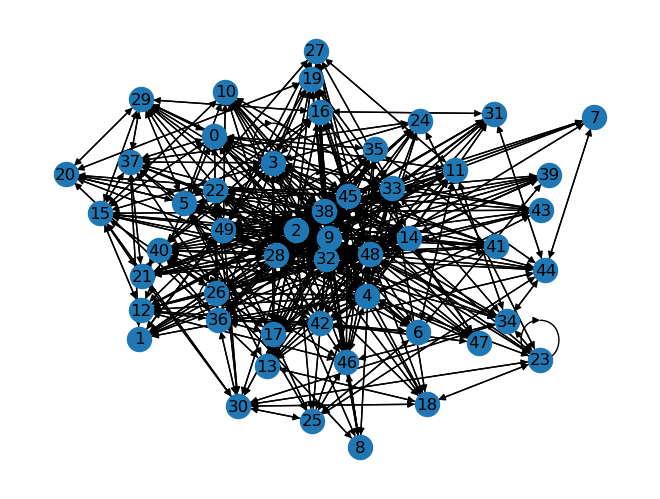

In [20]:
import networkx as nx
nx.draw(data.G, with_labels=True)

# Initial stats

Initial opinions stats 
mean: 0.5507159349710659
std: 0.27709911034986506
min: 0.05414230060026562
max: 0.9219130050887234


Text(0, 0.5, 'occurrences')

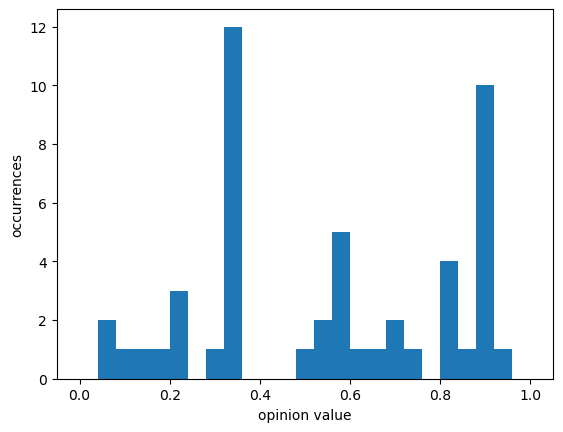

In [9]:
# print some basic statistics of initial opinions
opinions = opinion_diffusion_model.get_opinions()
print(f'Initial opinions stats \nmean: {opinions.mean()}\nstd: {opinions.std()}\nmin: {opinions.min()}\nmax: {opinions.max()}')

import matplotlib.pyplot as plt
_ = plt.hist(opinions, bins=25, range=[0,1])
plt.xlabel('opinion value')
plt.ylabel('occurrences')


## Equilibirum stats

In [10]:
# Diffusion: opinions are updated inplace
llm_node_id = 0
message_value = 1.
opinion_shift_vec = opinion_diffusion_model.propagate_message_at_equilibrium(message_value, llm_node_id)

Initial opinions stats 
mean: 0.5424882191111162
std: 0.14308987683592142
min: 0.2818903329548136
max: 0.7647896924867755


Text(0, 0.5, 'occurrences')

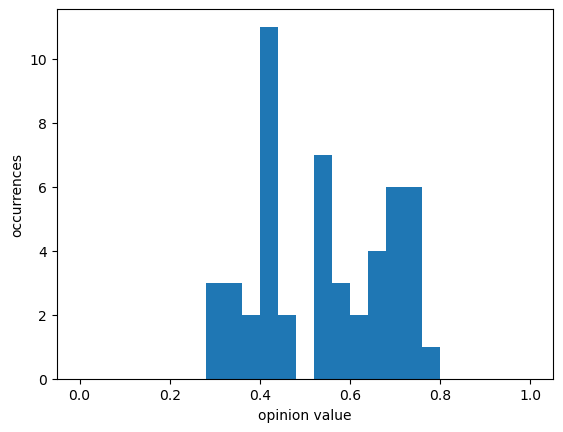

In [11]:
# print some basic statistics of equilibrium opinions
opinions = opinion_diffusion_model.get_opinions()
print(f'Initial opinions stats \nmean: {opinions.mean()}\nstd: {opinions.std()}\nmin: {opinions.min()}\nmax: {opinions.max()}')

import matplotlib.pyplot as plt
_ = plt.hist(opinions, bins=25, range=[0,1])
plt.xlabel('opinion value')
plt.ylabel('occurrences')


---